<a href="https://colab.research.google.com/github/Subh37106/Code-Gen-From-UDB-to-Implementations/blob/main/Case_study_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Environment Setup and Raw Data Generation:We generate a synthetic dataset of delivery stops located around a central depot. The feature vector $x_i$ includes spatial coordinates, package volume, and delivery time windows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

depot_coords = [34.05, -118.24]
n_stops = 400

data = {
    'stop_id': range(1, n_stops + 1),
    'coord_lat': np.concatenate([
        np.random.normal(34.12, 0.02, 150),
        np.random.normal(34.02, 0.02, 150),
        np.random.normal(34.05, 0.03, 100)
    ]),
    'coord_lon': np.concatenate([
        np.random.normal(-118.15, 0.02, 150),
        np.random.normal(-118.35, 0.02, 150),
        np.random.normal(-118.20, 0.04, 100)
    ]),
    'pkg_vol': np.random.randint(1, 10, n_stops),
    'time_win': np.random.randint(8, 17, n_stops)
}

df_raw = pd.DataFrame(data)

print("--- RAW DELIVERY STOP DATASET ---")
print(df_raw.head())

--- RAW DELIVERY STOP DATASET ---
   stop_id  coord_lat   coord_lon  pkg_vol  time_win
0        1  34.129934 -118.181889        2        13
1        2  34.117235 -118.161988        7        11
2        3  34.132954 -118.149895        1        16
3        4  34.150461 -118.149060        8        12
4        5  34.115317 -118.159001        3        12


2. 01 Spatial Scaling and Normalization:

Coordinates are normalized relative to the depot position. As noted in the study, spatial dimensions are weighted higher to ensure geographic contiguity of the zones.

In [2]:
df_scaled = df_raw.copy()
df_scaled['lat_rel'] = (df_raw['coord_lat'] - depot_coords[0]) * 1.5
df_scaled['lon_rel'] = (df_raw['coord_lon'] - depot_coords[1]) * 1.5

features = ['lat_rel', 'lon_rel', 'pkg_vol']
X = df_scaled[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

3. Determining K: The Elbow MethodIn logistics, $K$ typically equals the number of available drivers. However, we use the Elbow Method to find the most "natural" geographic zones for the distribution network.

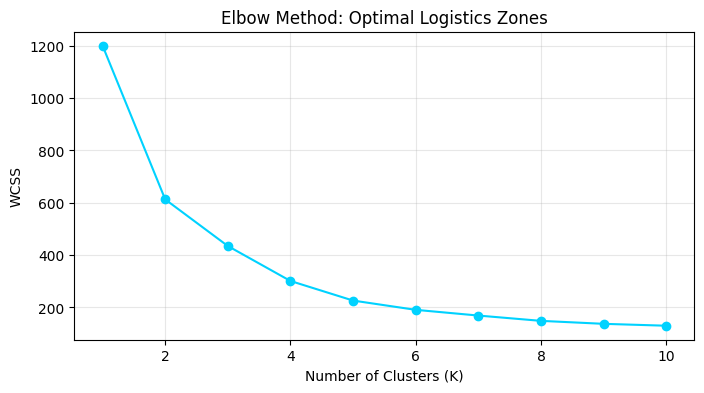

In [3]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    model.fit(X_scaled)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, wcss, marker='o', color='#00d2ff')
plt.title('Elbow Method: Optimal Logistics Zones')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(alpha=0.3)
plt.show()

4. 02 Zone Clustering (K=3):

  We cluster the stops into three primary zones (North, West, and East) based on   the "natural" groupings identified in the Elbow analysis and Case Study 06   diagram.

In [4]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
df_raw['zone_cluster'] = kmeans.fit_predict(X_scaled)

zone_map = {0: 'Zone A (North)', 1: 'Zone B (West)', 2: 'Zone C (East)'}
df_raw['Service_Area'] = df_raw['zone_cluster'].map(zone_map)

5. 03 Intra-Zone Optimization and Visualization:

We visualize the delivery stop zoning. In practice, the next step (Intra-Zone Optimization) involves solving the Traveling Salesman Problem (TSP) for each specific cluster.

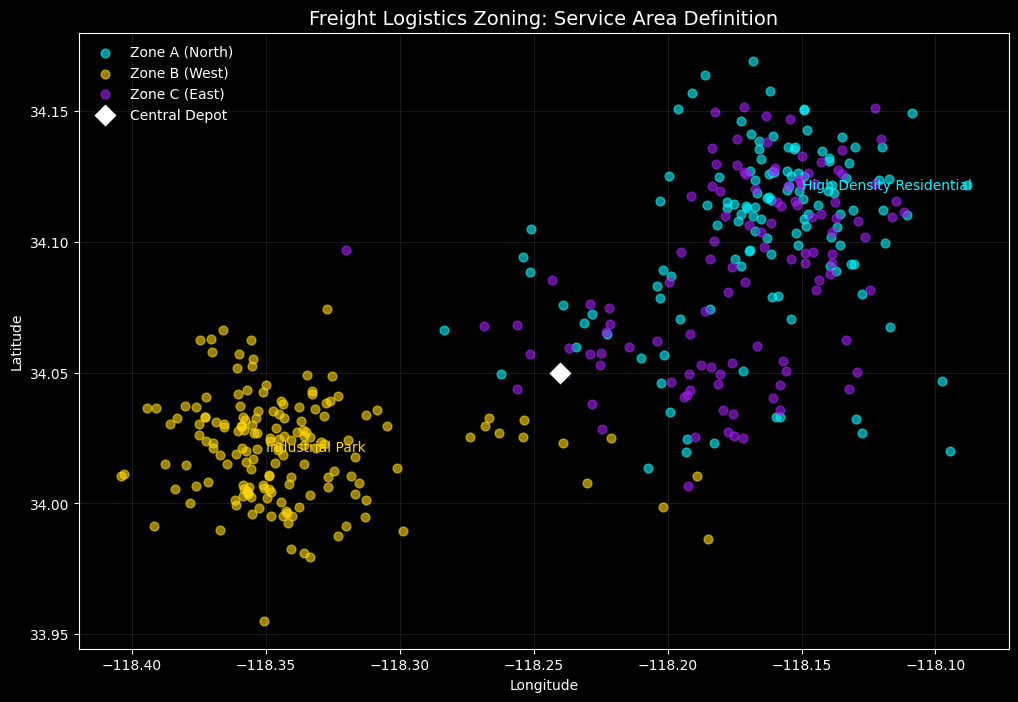

In [5]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))

colors = {'Zone A (North)': '#00F5FF', 'Zone B (West)': '#FFD700', 'Zone C (East)': '#A020F0'}

for zone, color in colors.items():
    subset = df_raw[df_raw['Service_Area'] == zone]
    plt.scatter(subset['coord_lon'], subset['coord_lat'], c=color, label=zone, alpha=0.6, s=40)

plt.scatter(depot_coords[1], depot_coords[0], color='white', marker='D', s=150, label='Central Depot', edgecolors='black')

plt.title('Freight Logistics Zoning: Service Area Definition', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(frameon=False, loc='upper left')
plt.grid(alpha=0.1)

plt.annotate('High Density Residential', xy=(-118.15, 34.12), color='#00F5FF', fontsize=10)
plt.annotate('Industrial Park', xy=(-118.35, 34.02), color='#FFD700', fontsize=10)

plt.show()

Summary of Results:

Reduced Stem Miles: Clustering stops geographically minimizes the distance from the depot to the first delivery point in each zone.

Workload Balance: K-means helps ensure that package counts (demand units) are distributed equitably across the identified service areas.

Operational Stability: By defining "fixed" territories, drivers become familiar with their zones, improving delivery speed and customer service.